<a href="https://colab.research.google.com/github/edaviesc/Global-Shop-Email-Campaign-Optimizer/blob/main/Globalshopemailcampaignoptimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:02:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Churn Prediction AUC: 0.4836
CLV Prediction R2: 0.7478


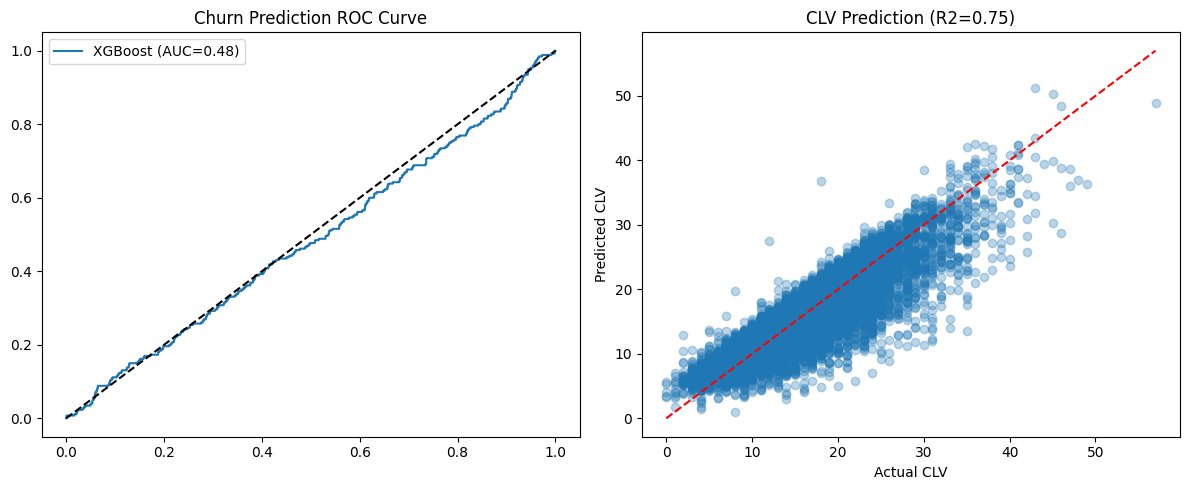

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, r2_score, roc_curve, mean_squared_error
from fastapi import FastAPI
import uvicorn

# 1. DATA PREPARATION & FEATURE ENGINEERING
df = pd.read_csv('/content/drive/MyDrive/data/globalshop_email_campaign.csv')

# Aggregating data to customer level
# Features: First 9 months; Targets: Last 3 months or Full Year
features = df[df['month'] <= 9].groupby('customer_id').agg({
    'emails_sent': ['sum', 'mean'],
    'opens': ['sum', 'mean'],
    'clicks': ['sum', 'mean'],
    'conversions': ['sum', 'mean']
})
features.columns = ['_'.join(col) for col in features.columns]

# Target 1: Churn (No activity in months 10-12)
activity_q4 = df[df['month'] > 9].groupby('customer_id')['clicks'].sum()
features['is_churned'] = (activity_q4 == 0).astype(int)

# Target 2: CLV (Total conversions over 12 months)
features['total_clv'] = df.groupby('customer_id')['conversions'].sum()

# 2. CHURN PREDICTION MODEL (XGBoost)
X = features.drop(['is_churned', 'total_clv'], axis=1)
y_churn = features['is_churned']

X_train, X_test, y_train, y_test = train_test_split(X, y_churn, test_size=0.2, random_state=42)

churn_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
churn_model.fit(X_train, y_train)

churn_probs = churn_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, churn_probs)
print(f"Churn Prediction AUC: {auc_score:.4f}")

# 3. CLV PREDICTION MODEL (XGBoost Regressor)
y_clv = features['total_clv']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clv, test_size=0.2, random_state=42)

clv_model = xgb.XGBRegressor(objective='reg:squarederror')
clv_model.fit(X_train_c, y_train_c)

clv_preds = clv_model.predict(X_test_c)
r2 = r2_score(y_test_c, clv_preds)
print(f"CLV Prediction R2: {r2:.4f}")

# 4. SEND TIME OPTIMIZATION (STO) & ROI FORECASTING
# Calculate individual Click-Through Rate (CTR) and optimal frequency
df['ctr'] = df['clicks'] / df['emails_sent'].replace(0, 1)
avg_ctr = df.groupby('customer_id')['ctr'].mean()

def optimize_roi(customer_id, cost_per_email=0.05, revenue_per_conv=25.0):
    # Predict conversions based on varying email frequency
    base_features = X.loc[[customer_id]]
    predicted_roi = []

    for count in range(1, 21): # Testing 1 to 20 emails
        temp_features = base_features.copy()
        temp_features['emails_sent_sum'] = count * 9
        conv_pred = clv_model.predict(temp_features)[0]

        roi = ((conv_pred * revenue_per_conv) - (count * cost_per_email)) / (count * cost_per_email)
        predicted_roi.append(roi)

    return np.argmax(predicted_roi) + 1

# 5. VISUALIZATIONS
plt.figure(figsize=(12, 5))

# Plot ROC Curve
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, churn_probs)
plt.plot(fpr, tpr, label=f'XGBoost (AUC={auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Churn Prediction ROC Curve')
plt.legend()

# Plot CLV Regression Performance
plt.subplot(1, 2, 2)
plt.scatter(y_test_c, clv_preds, alpha=0.3)
plt.plot([y_test_c.min(), y_test_c.max()], [y_test_c.min(), y_test_c.max()], 'r--')
plt.title(f'CLV Prediction (R2={r2:.2f})')
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.tight_layout()
plt.show()

# 6. REST API (FastAPI)
app = FastAPI()

@app.get("/predict/{customer_id}")
def get_predictions(customer_id: int):
    cust_data = X.loc[[customer_id]]
    churn_risk = churn_model.predict_proba(cust_data)[0][1]
    predicted_clv = clv_model.predict(cust_data)[0]
    opt_frequency = optimize_roi(customer_id)

    return {
        "customer_id": customer_id,
        "churn_probability": float(churn_risk),
        "estimated_clv": float(predicted_clv),
        "optimal_monthly_emails": int(opt_frequency)
    }

# To run API: uvicorn.run(app, host="0.0.0.0", port=8000)